_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install jupyter_black

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.9 MB/s eta 0:00:00


In [4]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

## Context
![image.png](attachment:image.png)

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

![image-3.png](attachment:image-3.png)

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [5]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["frequency", "direction", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(
    # path="/Users/lucakosina/Library/Mobile Documents/com~apple~CloudDocs/Uni/MASTER/neural data science/NeuralDataScience/data/project-01/"
    path="/content"
)

print("Overview of the data")
print_info(data)
print(data["stim_table"].head())
print(data["roi_masks"])

Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)

   frequency  direction  blank_sweep   start     end
0        1.0      225.0          0.0   747.0   807.0
1        2.0      180.0          0.0   837.0   897.0
2        4.0       90.0          0.0   927.0   987.0
3        1.0      270.0          0.0  1018.0  1077.0
4        4.0      135.0          0.0  1108.0  1168.0
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 

## Question

**Is there spatial structure in the preferred orientation/direction/frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of:
1. Pre-processing
2. Spike inference
3. Tuning function fitting
4. Statistical testing.

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

# Implementation

We are following these steps to answer the questions:

We filter the data to have smoother signals by cutting out low frequencies to be able to detect spikes in high-frequency components.
We then calculate the threshold for spikes and detect positions of spikes in the filtered data.
Because we are interested in the specificity of neurons to stimuls characteristics we look at each trial of stimulus presentation and segment the reactions of neurons in each stimulus segment.
Since only certain trials show detect spikes we filter out trials for each neurons in which spikes occur to continue the analysis with these.
We then correct each stimulus reaction to the baseline activity of the neuron before the stimulus presentation.
We then fit tuning curves to the detected spikes after stimulus presentation and by permutation analysis check which neurons have certain orientation, direction and frequency preference.
Then using the mask we plot the entire filed of neurons with their respective preference to first check if we can visually see an organization of the neurons into columns.
We statistically analyze this by ...



## Pre-processing

We start by looking at what the the raw data looks like for one example neuron:

In [6]:
data["dff"]

array([[0.08007366, 0.07333259, 0.10623901, ..., 0.12913607, 0.11774017,
        0.37138304],
       [0.3027197 , 0.19215527, 0.24838713, ..., 0.23082796, 0.0993453 ,
        0.3469142 ],
       [0.1681573 , 0.24385664, 0.11232736, ..., 0.11168884, 0.29000354,
        0.23824105],
       ...,
       [0.19818163, 0.1592283 , 0.21727051, ..., 0.20087314, 0.33797556,
        0.4996581 ],
       [0.23925741, 0.11036097, 0.16150714, ..., 0.13805537, 0.19728656,
        0.23281547],
       [0.14366886, 0.08441056, 0.03815553, ..., 0.09202033, 0.1976442 ,
        0.23586313]], dtype=float32)

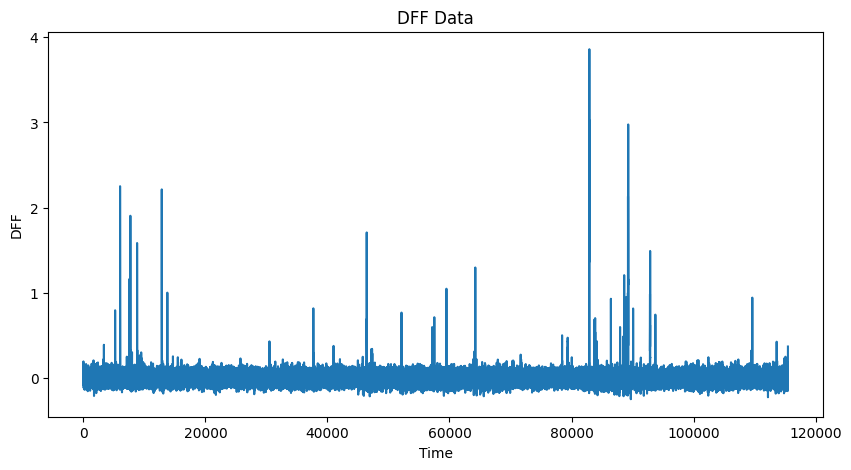

In [7]:
# plot dff
import matplotlib.pyplot as plt


def plot_dff(data, neuron=0):
    """
    Plot the dff data for a given neuron and stimulus epoch.

    Parameters:
    - data: The data dictionary containing dff data.
    - neuron: The index of the neuron to plot.
    - stim_epoch: The index of the stimulus epoch to plot.
    """
    dff = data["dff"]

    plt.figure(figsize=(10, 5))
    plt.plot(
        dff[neuron],
        label=f"Neuron {neuron}",
    )
    plt.title("DFF Data")
    plt.xlabel("Time")
    plt.ylabel("DFF")
    plt.show()


# Example plot for one neuron
plot_dff(data, neuron=0)

To see more of the frequency structure let´s look at a spcific segment of the data:

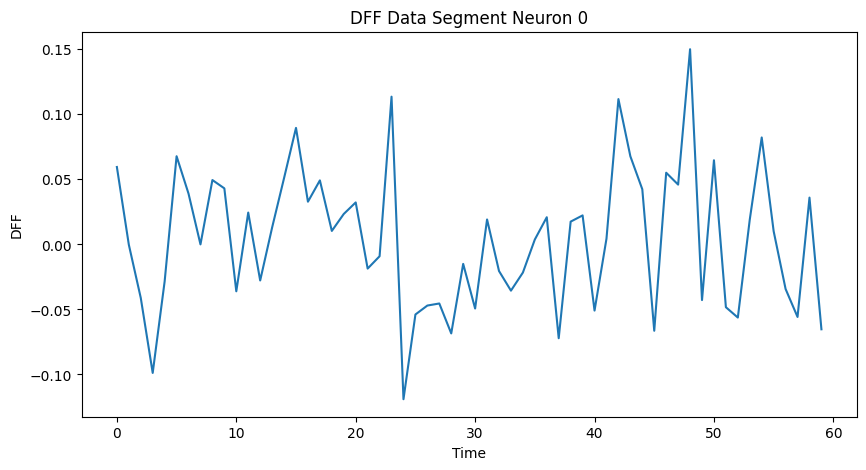

In [8]:
# look at specific trial / segment of the data for the example neuron
plt.figure(figsize=(10, 5))

# extzract stimulus epoch for the example neuron
stim_epoch = data["stim_table"].iloc[0]  # First stimulus epoch
start, end = int(stim_epoch["start"]), int(stim_epoch["end"])

plt.plot(
    data["dff"][0][start:end],
    label="Neuron 0",
)
plt.title("DFF Data Segment Neuron 0")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.show()

We can see that there is a slight low frequency oscillation in the data which we now want to filter out.

We are utilizing a butterworth filter like in the coding lab.

In [9]:
from scipy.signal import butter, filtfilt


def butterworth_filter(data, cutoff=0.1, fs=1.0, order=5):
    """
    Apply a Butterworth filter to the data.

    Parameters:
    - data: The data to filter.
    - cutoff: The cutoff frequency of the filter.
    - fs: The sampling frequency of the data.
    - order: The order of the filter.

    Returns:
    - The filtered data.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

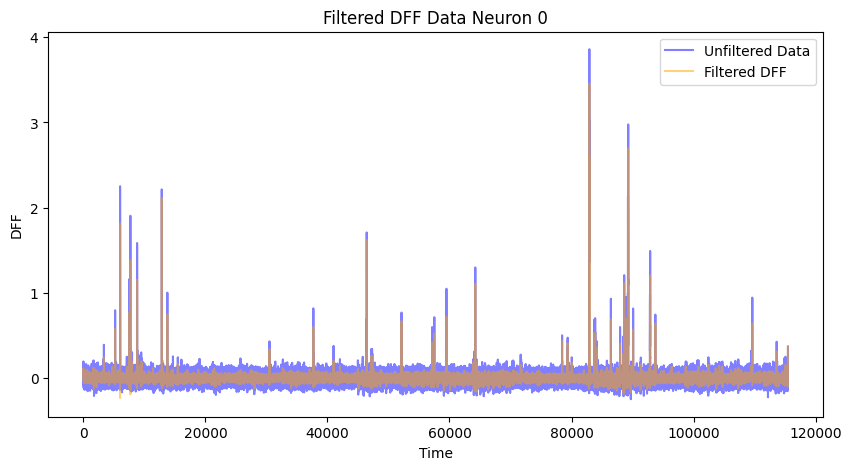

In [10]:
# Apply the filter to the dff data for one example neuron
filtered_dff = butterworth_filter(data["dff"][0], cutoff=0.1, fs=1.0, order=5)
# Plot the filtered dff data
plt.figure(figsize=(10, 5))
plt.plot(data["dff"][0], label=f"Unfiltered Data", color="blue", alpha=0.5)
plt.plot(filtered_dff, label="Filtered DFF", color="orange", alpha=0.5)
plt.title("Filtered DFF Data Neuron 0")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.legend()
plt.show()

The filtering process has smoothed the signal, reducing noise while preserving the essential features of the neural activity. This will help in further analyses such as identifying peaks, calculating statistics, or visualizing the data more clearly.
We can now therefore apply the filter to all neurons:

In [11]:
# apply filter to all neurons
filtered_dff_all = np.array(
    [butterworth_filter(d, cutoff=0.1, fs=1.0, order=5) for d in data["dff"]]
)

## Spike Inference

We can now continue with the analysis using the filtered data. First, we detect the spikes in the entire dataset for each neuron.

In [12]:
from scipy import signal


def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: float = 1.0
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes in the signal x and compute a threshold.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: float
        a window of 'refractory period', within which there's only one spike.
        Default is 1ms but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the signal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    You can use scipy functions like find_peaks for the detection.
    Note: There are four channels in signal x.

    """
    # compute the robust s.d. and calculate the threshold

    sigma = np.median(np.abs(x - np.mean(x))) / 0.6745
    threshold = N * sigma

    # Lockout in samples
    lockout_samples = int((lockout / 1000) * fs)

    # find all spikes

    # Candidate positive peaks
    pos_peaks, _ = signal.find_peaks(x, distance=lockout_samples)
    pos_peaks = pos_peaks[x[pos_peaks] >= threshold]

    # negative peaks are not used because they coocur too close to the positive peaks

    peaks = pos_peaks

    spike_times = peaks * (1000 / fs)  # convert to ms

    return peaks, spike_times, threshold

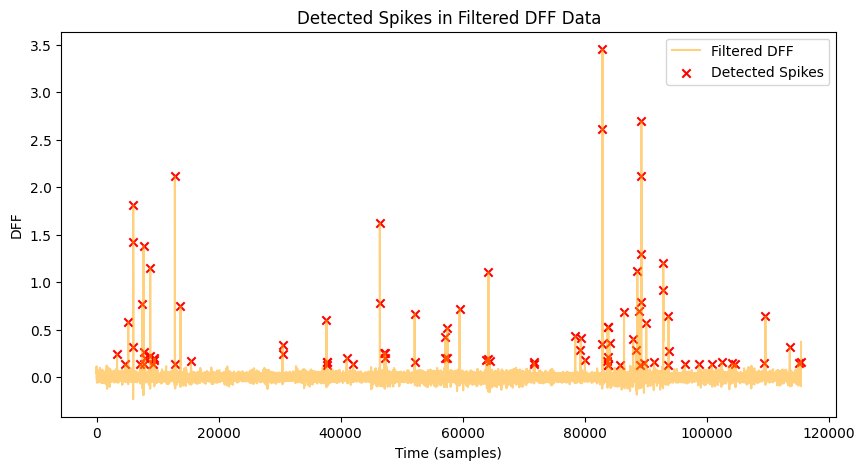

In [13]:
# detect spikes in the filtered dff data for example neuron
spikes, spike_times, threshold = detect_spikes(filtered_dff, fs=1000, N=5, lockout=1.0)

# plot the detected spikes
plt.figure(figsize=(10, 5))
plt.plot(filtered_dff, label="Filtered DFF", color="orange", alpha=0.5)
plt.scatter(
    spikes, filtered_dff[spikes], color="red", label="Detected Spikes", marker="x"
)
plt.title("Detected Spikes in Filtered DFF Data")
plt.xlabel("Time (samples)")
plt.ylabel("DFF")
plt.legend()
plt.show()

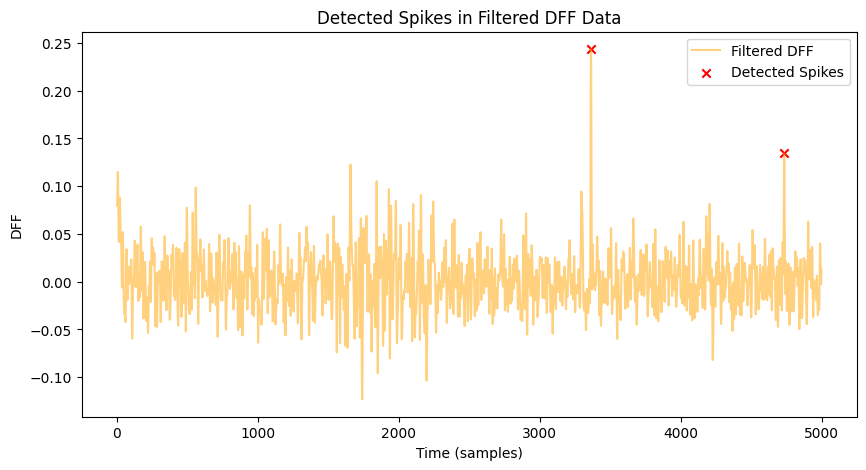

In [14]:
# look at specific short segment of the data

spikes, spike_times, threshold = detect_spikes(
    filtered_dff[0:5000], fs=5000, N=5, lockout=1.0
)


plt.figure(figsize=(10, 5))
plt.plot(filtered_dff[0:5000], label="Filtered DFF", color="orange", alpha=0.5)
# add spikes
plt.scatter(
    spikes,
    filtered_dff[spikes],
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Detected Spikes in Filtered DFF Data")
plt.xlabel("Time (samples)")
plt.ylabel("DFF")
plt.legend()
plt.show()

Again we apply the spike detection to all neurons:

In [15]:
# spike detection for all neurons
spikes_all = []
spike_times_all = []
thresholds_all = []
for dff in filtered_dff_all:
    spikes, spike_times, threshold = detect_spikes(dff, fs=1000, N=5, lockout=1.0)
    spikes_all.append(spikes)
    spike_times_all.append(spike_times)
    thresholds_all.append(threshold)

## Segment data by stimulus presentation and epochs

Since we want to analyze each neuron´s preference for direction and frequency we need to look at the signal directly after a stimulus presentation. Therefore, we split the data into segements for each trial.

In [16]:
stims = data["stim_table"]
stims

,frequency,direction,blank_sweep,start,end
0,1.0,225.0,0.0,747.0,807.0
1,2.0,180.0,0.0,837.0,897.0
2,4.0,90.0,0.0,927.0,987.0
3,1.0,270.0,0.0,1018.0,1077.0
4,4.0,135.0,0.0,1108.0,1168.0
...,...,...,...,...,...
623,4.0,315.0,0.0,114794.0,114854.0
624,2.0,45.0,0.0,114884.0,114944.0
625,4.0,180.0,0.0,114975.0,115034.0
626,4.0,270.0,0.0,115065.0,115125.0


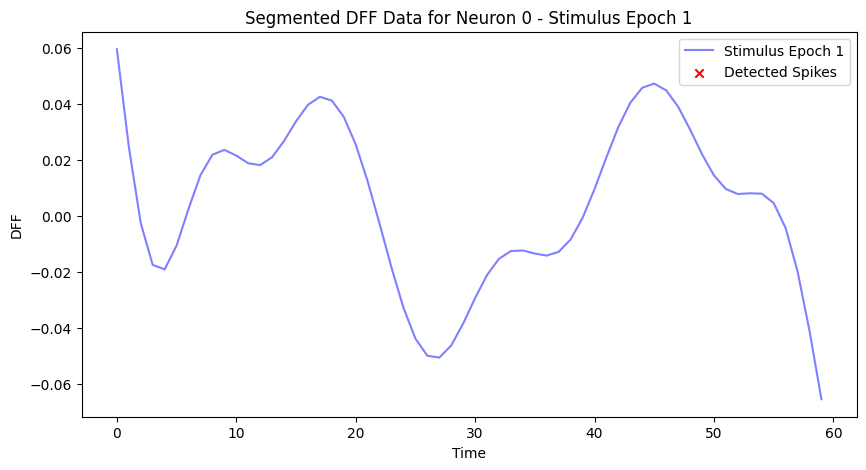

In [17]:
# split data for one example neuron into stimulus epochs
def segment_data_by_stimulus(data, neuron=0):
    """
    Segment the dff data for a given neuron into stimulus epochs.

    Parameters:
    - data: The data dictionary containing dff data and stimulus table.
    - neuron: The index of the neuron to segment.

    Returns:
    - A list of segmented dff data for each stimulus epoch.
    """
    dff = data["dff"][neuron]
    stim_table = data["stim_table"]

    segments = []
    for _, row in stim_table.iterrows():
        start, end = int(row["start"]), int(row["end"])
        segments.append(dff[start:end])

    return segments


# Example segmentation for one neuron
segmented_data = segment_data_by_stimulus(data, neuron=0)
# filter segemented data
filtered_segmented_data = [
    butterworth_filter(seg, cutoff=0.1, fs=1.0, order=5) for seg in segmented_data
]
# detect spikes in the segmented data for the first stimulus epoch
spikes_epoch_0, spike_times_epoch_0, threshold_epoch_0 = detect_spikes(
    filtered_segmented_data[0], fs=1000, N=5, lockout=1.0
)
# Plot the segmented data for the first stimulus epoch
plt.figure(figsize=(10, 5))
plt.plot(filtered_segmented_data[0], label="Stimulus Epoch 1", color="blue", alpha=0.5)
plt.scatter(
    spikes_epoch_0,
    filtered_segmented_data[1][spikes_epoch_0],
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Segmented DFF Data for Neuron 0 - Stimulus Epoch 1")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.legend()
plt.show()

The segmentation for the first stimulus epoch worked, so we can apply it to all neurons. However, we can see no spike in this epoch. Therefore we then select the segments that have spikes to only extract tuning curves from them later.

In [18]:
# segment all neurons by stimulus epochs
def segment_all_neurons_by_stimulus(data):
    """
    Segment the dff data for all neurons into stimulus epochs.

    Parameters:
    - data: The data dictionary containing dff data and stimulus table.

    Returns:
    - A list of lists, where each inner list contains segmented dff data for each neuron.
    """
    segmented_data = []
    for neuron in range(data["dff"].shape[0]):
        segments = segment_data_by_stimulus(data, neuron)
        segmented_data.append(segments)

    return segmented_data


# Segment all neurons by stimulus epochs
segmented_data_all = segment_all_neurons_by_stimulus(data)

In [19]:
# select segments that have spikes
def select_segments_with_spikes(segmented_data, threshold=5):
    """
    Select segments that have spikes based on a threshold.

    Parameters:
    - segmented_data: A list of lists containing segmented dff data for each neuron.
    - threshold: The minimum number of spikes required to keep a segment.

    Returns:
    - A list of lists, where each inner list contains segments with spikes for each neuron.
    """
    selected_segments = []
    for neuron_segments in segmented_data:
        neuron_selected = []
        for segment in neuron_segments:
            spikes, _, _ = detect_spikes(segment, fs=1000, N=threshold, lockout=1.0)
            if len(spikes) > 0:
                neuron_selected.append(segment)
        selected_segments.append(neuron_selected)

    return selected_segments


# Select segments with spikes for all neurons
selected_segments_all = select_segments_with_spikes(segmented_data_all, threshold=5)

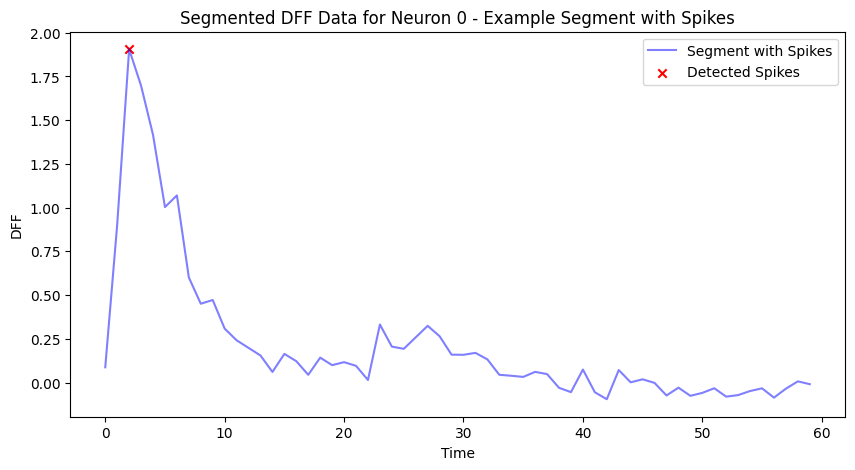

In [20]:
# plot example segement with spikes
plt.figure(figsize=(10, 5))
plt.plot(
    selected_segments_all[0][0], label="Segment with Spikes", color="blue", alpha=0.5
)
spikes, spike_times, _ = detect_spikes(
    selected_segments_all[0][0], fs=1000, N=5, lockout=1.0
)
plt.scatter(
    spikes,
    selected_segments_all[0][0][spikes],
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Segmented DFF Data for Neuron 0 - Example Segment with Spikes")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.legend()
plt.show()

Now we will correct each stimulus reaction spike by the baseline for which we use the activity in the timewindow of 10 ms before.

In [21]:
# baseline correction for each stimulus segement with activity in the timewindow of 10 ms before the segment
def baseline_correction(segments, fs=1000, baseline_window=50):
    """
    Apply baseline correction to each segment by subtracting the mean activity in the baseline window.

    Parameters:
    - segments: A list of lists containing segmented dff data for each neuron.
    - fs: The sampling frequency of the data.
    - baseline_window: The duration of the baseline window in milliseconds.

    Returns:
    - A list of lists, where each inner list contains baseline-corrected segments for each neuron.
    """
    corrected_segments = []
    baseline_samples = int((baseline_window / 1000) * fs)

    for neuron_segments in segments:
        neuron_corrected = []
        for segment in neuron_segments:
            baseline = np.mean(segment[:baseline_samples])
            corrected_segment = segment - baseline
            neuron_corrected.append(corrected_segment)
        corrected_segments.append(neuron_corrected)

    return corrected_segments


# Apply baseline correction to the selected segments with spikes
corrected_segments_all = baseline_correction(
    selected_segments_all, fs=1000, baseline_window=10
)

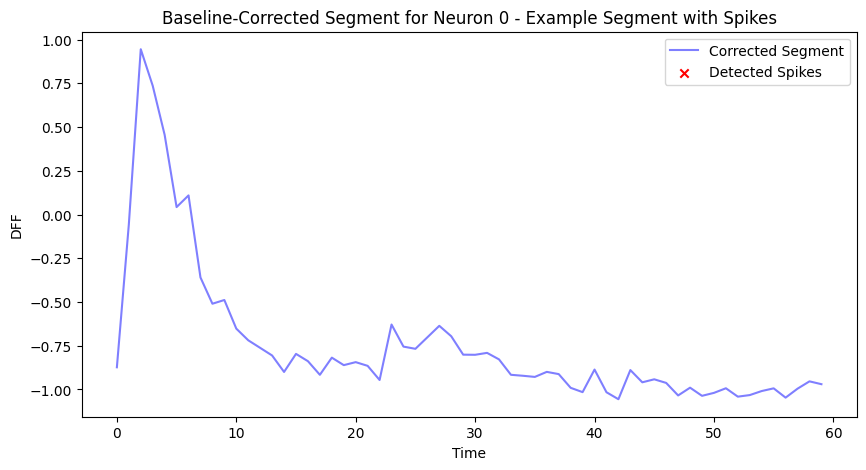

In [22]:
# plot example corrected segment
plt.figure(figsize=(10, 5))
plt.plot(
    corrected_segments_all[0][0], label="Corrected Segment", color="blue", alpha=0.5
)
spikes, spike_times, _ = detect_spikes(
    corrected_segments_all[0][0], fs=1000, N=5, lockout=1.0
)
plt.scatter(
    spikes,
    corrected_segments_all[0][0][spikes],
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Baseline-Corrected Segment for Neuron 0 - Example Segment with Spikes")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.legend()
plt.show()

## Tuning functions